# Data Undetstanding

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('/Users/xiaoming/Library/CloudStorage/OneDrive-AsiaPacificUniversity/Degree Y3S2/FYP/retail_store_inventory.csv')

##### NORMAL  INFORMATION (ROW+COLUMN AMOUNTS AND ATTRIBUTES DATA TYPES)

In [3]:
print("ROW, COLUMNS: \n", df.shape)
print("\nATTRIBUTES DATA TYPES: \n", df.dtypes)


ROW, COLUMNS: 
 (73100, 15)

ATTRIBUTES DATA TYPES: 
 Date                   object
Store ID               object
Product ID             object
Category               object
Region                 object
Inventory Level         int64
Units Sold              int64
Units Ordered           int64
Demand Forecast       float64
Price                 float64
Discount                int64
Weather Condition      object
Holiday/Promotion       int64
Competitor Pricing    float64
Seasonality            object
dtype: object


##### NORMAL DATA INFORMATION (NULL AND DUPLICATES)

In [4]:
print("\nMISSING DATA: \n",df.isnull().sum())
print("\nDUPLICATES DATA: ",df.duplicated().sum())



MISSING DATA: 
 Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

DUPLICATES DATA:  0


##### TOTAL UNIQUE VALUE FOR CATEGORY COLUMNS

In [5]:
print("UNIQUE VALUE:")
for col in ['Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition', 'Seasonality']:
    print(f"{col}: {df[col].nunique()} unique values")

UNIQUE VALUE:
Store ID: 5 unique values
Product ID: 20 unique values
Category: 5 unique values
Region: 4 unique values
Weather Condition: 4 unique values
Seasonality: 4 unique values


##### RANGE OF NUMERIC ATTRIBUTES

In [6]:
num_cols = ['Inventory Level', 'Units Sold', 'Units Ordered',
            'Demand Forecast', 'Price', 'Discount', 'Competitor Pricing',]
print("\nNumerical Columns Stats:")
print(df[num_cols].describe())


Numerical Columns Stats:
       Inventory Level    Units Sold  Units Ordered  Demand Forecast  \
count     73100.000000  73100.000000   73100.000000     73100.000000   
mean        274.469877    136.464870     110.004473       141.494720   
std         129.949514    108.919406      52.277448       109.254076   
min          50.000000      0.000000      20.000000        -9.990000   
25%         162.000000     49.000000      65.000000        53.670000   
50%         273.000000    107.000000     110.000000       113.015000   
75%         387.000000    203.000000     155.000000       208.052500   
max         500.000000    499.000000     200.000000       518.550000   

              Price      Discount  Competitor Pricing  
count  73100.000000  73100.000000        73100.000000  
mean      55.135108     10.009508           55.146077  
std       26.021945      7.083746           26.191408  
min       10.000000      0.000000            5.030000  
25%       32.650000      5.000000           3

In [7]:
print(df.head())

         Date Store ID Product ID     Category Region  Inventory Level  \
0  2022-01-01     S001      P0001    Groceries  North              231   
1  2022-01-01     S001      P0002         Toys  South              204   
2  2022-01-01     S001      P0003         Toys   West              102   
3  2022-01-01     S001      P0004         Toys  North              469   
4  2022-01-01     S001      P0005  Electronics   East              166   

   Units Sold  Units Ordered  Demand Forecast  Price  Discount  \
0         127             55           135.47  33.50        20   
1         150             66           144.04  63.01        20   
2          65             51            74.02  27.99        10   
3          61            164            62.18  32.72        10   
4          14            135             9.26  73.64         0   

  Weather Condition  Holiday/Promotion  Competitor Pricing Seasonality  
0             Rainy                  0               29.69      Autumn  
1           

In [8]:
df["Date"] = pd.to_datetime(df["Date"])
print(df.dtypes)

Date                  datetime64[ns]
Store ID                      object
Product ID                    object
Category                      object
Region                        object
Inventory Level                int64
Units Sold                     int64
Units Ordered                  int64
Demand Forecast              float64
Price                        float64
Discount                       int64
Weather Condition             object
Holiday/Promotion              int64
Competitor Pricing           float64
Seasonality                   object
dtype: object


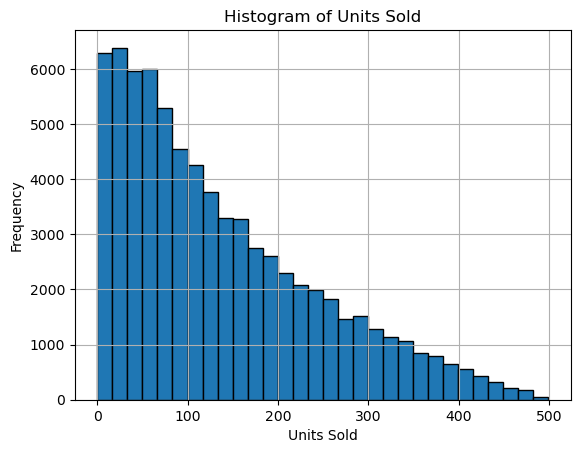

Skewness: 0.9053326253493985


In [9]:
import matplotlib.pyplot as plt

# Plot histogram for 'Units Sold'
df['Units Sold'].hist(bins=30, edgecolor='black')
plt.title('Histogram of Units Sold')
plt.xlabel('Units Sold')
plt.ylabel('Frequency')
plt.show()


# For a particular column
skewness = df['Units Sold'].skew()
print(f"Skewness: {skewness}")

df['Units Sold'] = np.sqrt(df['Units Sold'])

#

#

#

# Model Building

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Assuming 'df' is the DataFrame containing your data

# Select features and target
X = df[['Price', 'Discount', 'Competitor Pricing', 'Inventory Level', 'Units Ordered'] + list(df.columns[df.columns.str.startswith('Seasonality')])]
y = df['Units Sold']

# Normalize the features using MinMaxScaler (scaling between 0 and 1)
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

# Normalize the target variable (Units Sold)
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 3. Create Lagged Data for Time-Series Forecasting
def create_lagged_data(X, y, lag=1):
    """
    Convert the data into a supervised learning problem by creating lagged features
    (previous time steps) to predict the target variable.
    """
    X_lagged = []
    y_lagged = []
    
    for i in range(lag, len(X)):
        X_lagged.append(X[i-lag:i])  # Create lagged features
        y_lagged.append(y[i])  # Target (Units Sold) corresponding to the lagged data
        
    return np.array(X_lagged), np.array(y_lagged)

# Let's create lagged data. For example, using the past 7 days' data to predict the next day's Units Sold
X_lagged, y_lagged = create_lagged_data(X_scaled, y_scaled, lag=7)

# 4. Reshape the Data into 3D format (samples, timesteps, features)
# LSTM expects data in the format (samples, timesteps, features)
X_lagged = X_lagged.reshape((X_lagged.shape[0], X_lagged.shape[1], X_lagged.shape[2]))

# Now, X_lagged is ready to be used for training the LSTM model

ValueError: could not convert string to float: 'Autumn'

In [ ]:
# Visualize the scaled 'Units Sold'
plt.plot(y_scaled[:100], label="Scaled Units Sold")
plt.title("Scaled Units Sold (First 100 Data Points)")
plt.xlabel("Time")
plt.ylabel("Scaled Units Sold")
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()

# Adding the first LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_lagged.shape[1], X_lagged.shape[2])))
model.add(Dropout(0.2))  # Adding Dropout for regularization

# Adding the second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))  # Output layer (prediction of 'Units Sold')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()

# Train the model
history = model.fit(X_lagged, y_lagged, epochs=50, batch_size=32, validation_split=0.2, verbose=1)